 ## CHIVI expts on linear regression in high dimensions

In [2]:
import sys, os
sys.path.append('..')
sys.path.append('../..')
import autograd
import pickle
import pystan

In [3]:


import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       black_box_chivi_neff,
                       perturbed_black_box_vi,
                       make_stan_log_density,
                       adagrad_optimize, 
                     
                      )
from experiments import (get_samples_and_log_weights, 
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

In [4]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

In [5]:

regression_model_code = """data {
  int<lower=0> N;   // number of observations
  int<lower=0> D;   // number of observations
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[D] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(40, x * beta, 1);  // likelihood
  #y ~ normal( x * beta, 0.5);  // likelihood
}"""

In [6]:
try:
    sm = pickle.load(open('robust_reg_model_t.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_t.pkl', 'wb') as f:
        pickle.dump(sm, f)



### First we take D=14

In [ ]:
N=80
k=14
SEED= 5080
alpha=1.
noise_sigma=0.5
noise_var = noise_sigma**2
rho = 0.1
regression_data = data_generator_linear(N, k, alpha=alpha,noise_variance=noise_var,rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

In [13]:
lims1 = dict(xlim=[-1.7,0.1], ylim=[-0.2,1.2])
lims2 = dict(xlim=[1.7,3.2], ylim=[-1.1,0.2])

In [ ]:
#data = dict(N=N, x=x, y=y, D=k)
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [ ]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
true_std = np.sqrt(np.diag(true_cov))

In [ ]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)
mf_t_var_family= mean_field_t_variational_family(k, df=40)
stan_log_density = make_stan_log_density(fit)
chivi_mf_objective_and_grad_pd = black_box_chivi(2, mf_g_var_family, stan_log_density, 2000)
chivi_t_mf_objective_and_grad_pd = black_box_chivi(2, mf_t_var_family, stan_log_density, 2000)
chivi_fr_objective_and_grad_pd = black_box_chivi(2, fr_g_var_family, stan_log_density, 2000)

In [ ]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(k, 10)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

#plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

### KLVI solution

In [ ]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims1,
                               savepath='figures/robust-regression-mf-klvi-good_new.pdf', aux_var = true_mean[2:])

#### make KLVI solution overdispersed

In [ ]:
mf_t_var_family = mean_field_t_variational_family(k, 5)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_param1 = klvi_var_param.copy()
print(init_param1.shape)
init_param1[k:] +=0.6

In [ ]:
a,b,c,d = adagrad_optimize(6000, chivi_objective_and_grad,  init_param1, False, window=10, learning_rate=.01, learning_rate_end=0.002)

In [ ]:
#a1,b1,c1,d1 = adagrad_optimize(600, chivi_objective_and_grad,  a, False, window=10, learning_rate=.01, learning_rate_end=0.002)

#### PLot of CUBO

In [ ]:
print(klvi_var_param)
print(a)
#print(b[-1])
print(true_mean)
print(np.log(true_std))

plt.plot(c)
plt.ylabel('objective')
plt.xlabel('Iterations')
plt.savefig('figures/good_chivi_run_new1.pdf')
print(c[0])
print(c[-1])

In [ ]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, a, **lims1,
                               savepath='figures/robust-regression-mf-chivi-good_new1.pdf', aux_var = true_mean[2:])

In [ ]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_param1, **lims1,
                               savepath='figures/robust-regression-mf-chivi-init1.pdf', aux_var = true_mean[2:])

###  Bad run, let us take D=30

In [7]:
N=90
k=30
SEED= 5080
alpha=1.
noise_sigma=0.5
noise_var = noise_sigma**2
rho = 0.1
regression_data = data_generator_linear(N, k, alpha=alpha,noise_variance=noise_var,rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

In [8]:
#data = dict(N=N, x=x, y=y, D=k)
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [9]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
true_std = np.sqrt(np.diag(true_cov))

In [10]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)
mf_t_var_family= mean_field_t_variational_family(k, df=40)
stan_log_density = make_stan_log_density(fit)
chivi_mf_objective_and_grad_pd = black_box_chivi(2, mf_g_var_family, stan_log_density, 600)
chivi_t_mf_objective_and_grad_pd = black_box_chivi(2, mf_t_var_family, stan_log_density, 600)
chivi_fr_objective_and_grad_pd = black_box_chivi(2, fr_g_var_family, stan_log_density, 600)

In [11]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(k, 10)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 6000

#plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = 93.16: 100%|██████████| 6000/6000 [00:44<00:00, 136.03it/s] 


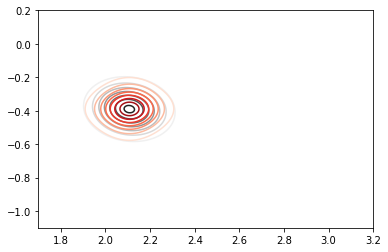

In [14]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims2,
                               savepath='figures/robust-regression-mf-klvi-bad_new_1.pdf', aux_var = true_mean[2:])

In [15]:
mf_t_var_family = mean_field_t_variational_family(k, 8)
chivi_objective_and_grad = black_box_chivi_neff(2, mf_t_var_family, stan_log_density, 500)

init_param1 = klvi_var_param.copy()
print(init_param1.shape)
init_param1[k:] += 1.2

(60,)


In [ ]:
a1,b1,c1,d1 = adagrad_optimize(1400, chivi_objective_and_grad,  init_param1, False, window=10, learning_rate=.004, learning_rate_end=0.0001)

Average Loss = -62.513:  33%|███▎      | 460/1400 [00:27<00:53, 17.54it/s]

[ 2.107849   -0.38926655 -0.47548721  1.70539101  0.01792756  0.44905026
  0.08557676  0.12501176  1.05727024 -1.01071255 -0.27542239  0.51884498
 -0.82683913 -0.05545258 -1.56766917 -0.82879026 -0.45432806 -1.40039733
  0.05868357  0.95003692 -1.2903244  -0.34145529  0.26676693  0.08199261
 -1.03188473  0.20511306 -0.27190747 -0.4928862  -2.69851165  0.89668356
 -2.37374953 -2.42916877 -2.30843647 -2.38465948 -2.2720462  -2.21637637
 -2.38256208 -2.29955654 -2.37793525 -2.33755952 -2.29784835 -2.4992964
 -2.42387386 -2.26919082 -2.30351993 -2.42101311 -2.16790014 -2.33541616
 -2.3114862  -2.43847468 -2.37613036 -2.19522686 -2.40581461 -2.28425813
 -2.40418741 -2.45320112 -2.44171267 -2.27822173 -2.33484698 -2.42385857]
[ 2.10351901 -0.38794647 -0.47762492  1.69748291  0.00767425  0.45042824
  0.08179131  0.11742211  1.05494153 -1.00833204 -0.28013925  0.52199349
 -0.82059191 -0.05774773 -1.55733291 -0.83085738 -0.45216437 -1.40820126
  0.05310758  0.95057858 -1.28963733 -0.3401903   0

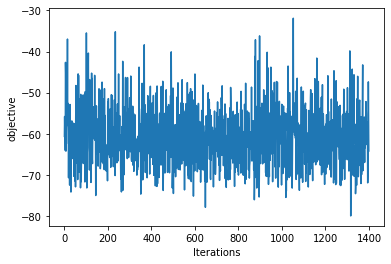

In [25]:
print(klvi_var_param)
print(a1)
#print(b[-1])
print(true_mean)
print(np.log(true_std))

plt.plot(c1)
plt.ylabel('objective')
plt.xlabel('Iterations')
plt.savefig('figures/chivi_run_new_neff1.pdf')


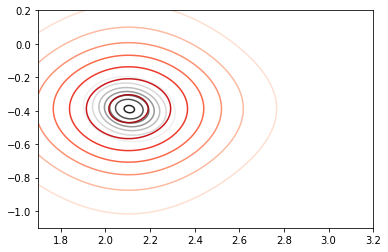

In [26]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, a1, **lims2,
                               savepath='figures/robust-regression-mf-chivi-neff_1.pdf', aux_var = true_mean[2:])